In [27]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

sellers = pd.read_csv("", sep = ';', skiprows=[1]) # sellers csv address
ratings = pd.read_csv("", sep = ';', skiprows=[1]) # ratings csv address

In [26]:
sellers.head()

,p.iva,Unnamed: 1,nome,Unnamed: 3,categoria,Unnamed: 5,indirizzo,Unnamed: 7,telefono
0,0,NaN,Agricoltura.srl,NaN,ortaggi,NaN,"46.147688, 13.124891",NaN,3486237709
1,1,NaN,Azienda1,NaN,ortofrutta,NaN,"46.091326, 13.451818",NaN,3406572201
2,2,NaN,Azienda2,NaN,macelleria,NaN,"45.702015, 12.851531",NaN,3489087687
3,3,NaN,Azienda3,NaN,falegnameria,NaN,"45.675101, 12.855418",NaN,3489907855
4,4,NaN,Azienda4,NaN,ortaggi,NaN,"45.728710, 12.955894",NaN,3409963345


In [28]:
ratings.head()

,id_utente,Unnamed: 1,p.iva,Unnamed: 3,valutazioni,Unnamed: 5,timestamp,Unnamed: 7,consegna_domicilio,Unnamed: 9,prezzo,Unnamed: 11,distanza,Unnamed: 13,rating,Unnamed: 15,valutazione_distanza
0,0,NaN,0,NaN,4,NaN,98898,NaN,0,NaN,1,NaN,12,NaN,17,NaN,4
1,1,NaN,1,NaN,"4,5",NaN,80000,NaN,1,NaN,3,NaN,40,NaN,"48,5",NaN,3
2,2,NaN,2,NaN,5,NaN,90000,NaN,1,NaN,2,NaN,20,NaN,28,NaN,4
3,3,NaN,3,NaN,3,NaN,75550,NaN,1,NaN,1,NaN,28,NaN,33,NaN,4
4,4,NaN,4,NaN,"3,5",NaN,75000,NaN,0,NaN,2,NaN,18,NaN,"23,5",NaN,4


In [29]:
final_dataset = ratings.pivot(index="p.iva", columns="id_utente", values="valutazioni")
final_dataset.head()

id_utente,0,1,2,3,4,5,6,7,8,9
p.iva,,,,,,,,,,
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"4,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,"3,5",NaN,NaN,NaN,NaN,NaN


In [30]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

id_utente,0,1,2,3,4,5,6,7,8,9
p.iva,,,,,,,,,,
0,4,0,0,0,0,0,0,0,0,0
1,0,"4,5",0,0,0,0,0,0,0,0
2,0,0,5,0,0,0,0,0,0,0
3,0,0,0,3,0,0,0,0,0,0
4,0,0,0,0,"3,5",0,0,0,0,0


In [32]:
no_user_voted = ratings.groupby('p.iva')['rating'].agg('count')
no_movies_voted = ratings.groupby('id_utente')['rating'].agg('count')

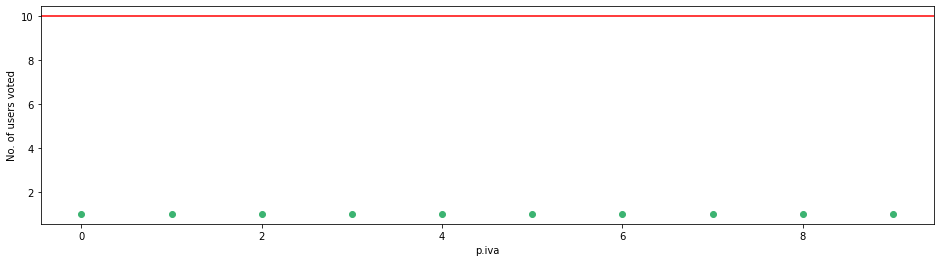

In [33]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel("p.iva")
plt.ylabel('No. of users voted')
plt.show()

In [34]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

id_utente
p.iva
0
1
2
3
4
5
6
7
8


We are using only a small dataset but for the original large dataset of movie lens which has more than 100000 features, our system may run out of computational resources when that is feed to the model. To reduce the sparsity we use the csr_matrix function from the scipy library.

Here is an example of how it works.

In [35]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [36]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [37]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [42]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_sample) # test

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [50]:
def get_sellers_recommendation(seller_name):
    n_sellers_to_reccomend = 10
    sellers_list = sellers[sellers['nome'].str.contains(seller_name)]  
    if len(sellers_list):        
        seller_idx= sellers_list.iloc[0]['p.iva']
        seller_idx = final_dataset[final_dataset['p.iva'] == seller_idx].index[0]
        distances , indices = knn.kneighbors(csr_sample[seller_idx],n_neighbors=n_sellers_to_reccomend+1)    
        rec_seller_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_seller_indices:
            seller_idx = final_dataset.iloc[val[0]]['p.iva']
            idx = sellers[sellers['p.iva'] == seller_idx].index
            recommend_frame.append({'Name':sellers.iloc[idx]['nome'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_sellers_to_reccomend+1))
        return df
    else:
        return "No sellers found. Please check your input"

In [ ]:
get_sellers_recommendation("nome_azienda")